In [1]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
from graphmodels.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
import pandas as pd
import plotly.express as px
from sklearn.metrics import r2_score
from database import select_dataset

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]#.fillna(0)
    return X


def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='GGI_code', values='Value')

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y

In [30]:
df = pd.read_csv('models/Hermen/data/GY_GE_GU_GM_GP_GT.csv')
pop = select_dataset('population')
data_dict = df_to_dict(pivot(df))
data_dict['Pop'] = pop.set_index(['Area', 'Year'])['Value']
data_dict['OEi'] = data_dict['OEi'].reset_index(level='Item', drop='True').dropna()

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
from models.Hermen.model_GE3 import GE3_models
res = []
for model_name, model in GE3_models.items():
    print(model_name)
    X, y = get_X_y_from_data(model, data_dict)
    
    print(score_model(model, X, y))


TMi_model
    r2  correlation          rmse Variable
0  1.0          1.0  1.053919e-15      TMi
M_xi_model
    r2  correlation          rmse Variable
0  1.0          1.0  7.382541e-16     M_Ti
1  1.0          1.0  8.550658e-16    M_LPi
2  1.0          1.0  5.858794e-16    M_ASi
TMP_CO2eq_model
         r2  correlation       rmse   Variable
0  0.999997     0.999999  17.156806  TMP_CO2eq
TMT_CO2eq_model
         r2  correlation          rmse   Variable
0  0.999992     0.999997  2.536710e-05       E_Ti
1  1.000000     1.000000  1.259033e-08    E_TCH4i
2  0.999997     0.999999  2.438036e+00  TMT_CO2eq
TMA_CO2eq_model
         r2  correlation      rmse   Variable
0  0.999993          1.0  1.748403  TMA_CO2eq
TEE_CO2eq_model
    r2  correlation          rmse   Variable
0  1.0          1.0  4.388695e-10  TEE_CO2eq
FE_CO2eq_model
         r2  correlation         rmse  Variable
0  0.999987     0.999994  2401.629787  FE_CO2eq
GE3_partial_model
Empty DataFrame
Columns: []
Index: []
GE3_model
    

In [32]:
model = GE3_models['GE3_model']
X, y = get_X_y_from_data(model, data_dict)
    
score_model(model, X, y)

,r2,correlation,rmse,Variable
0,1.000000,1.000000,4.388695e-10,TEE_CO2eq
1,0.999997,0.999999,2.438036e+00,TMT_CO2eq
2,0.999993,1.000000,1.748403e+00,TMA_CO2eq
3,0.999997,0.999999,1.715681e+01,TMP_CO2eq
4,0.999987,0.999994,2.401630e+03,FE_CO2eq
5,1.000000,1.000000,3.124699e-16,M_ASi
6,1.000000,1.000000,3.314249e-16,M_Ti
7,0.999992,0.999997,2.536710e-05,E_Ti
8,1.000000,1.000000,1.259033e-08,E_TCH4i
9,1.000000,1.000000,5.881967e-16,M_LPi


In [33]:
GE3 = model.run(X)['GE3']

In [35]:
GE3.dropna().loc['France']

Year
2014    90.327899
2015    91.814856
2016    73.467213
2017    86.901221
2018    80.491065
dtype: float64

In [36]:
GE3.dropna().loc['Germany']

Year
2014    96.086742
2015    93.700888
2016    90.401751
2017    90.117010
2018    83.829965
dtype: float64

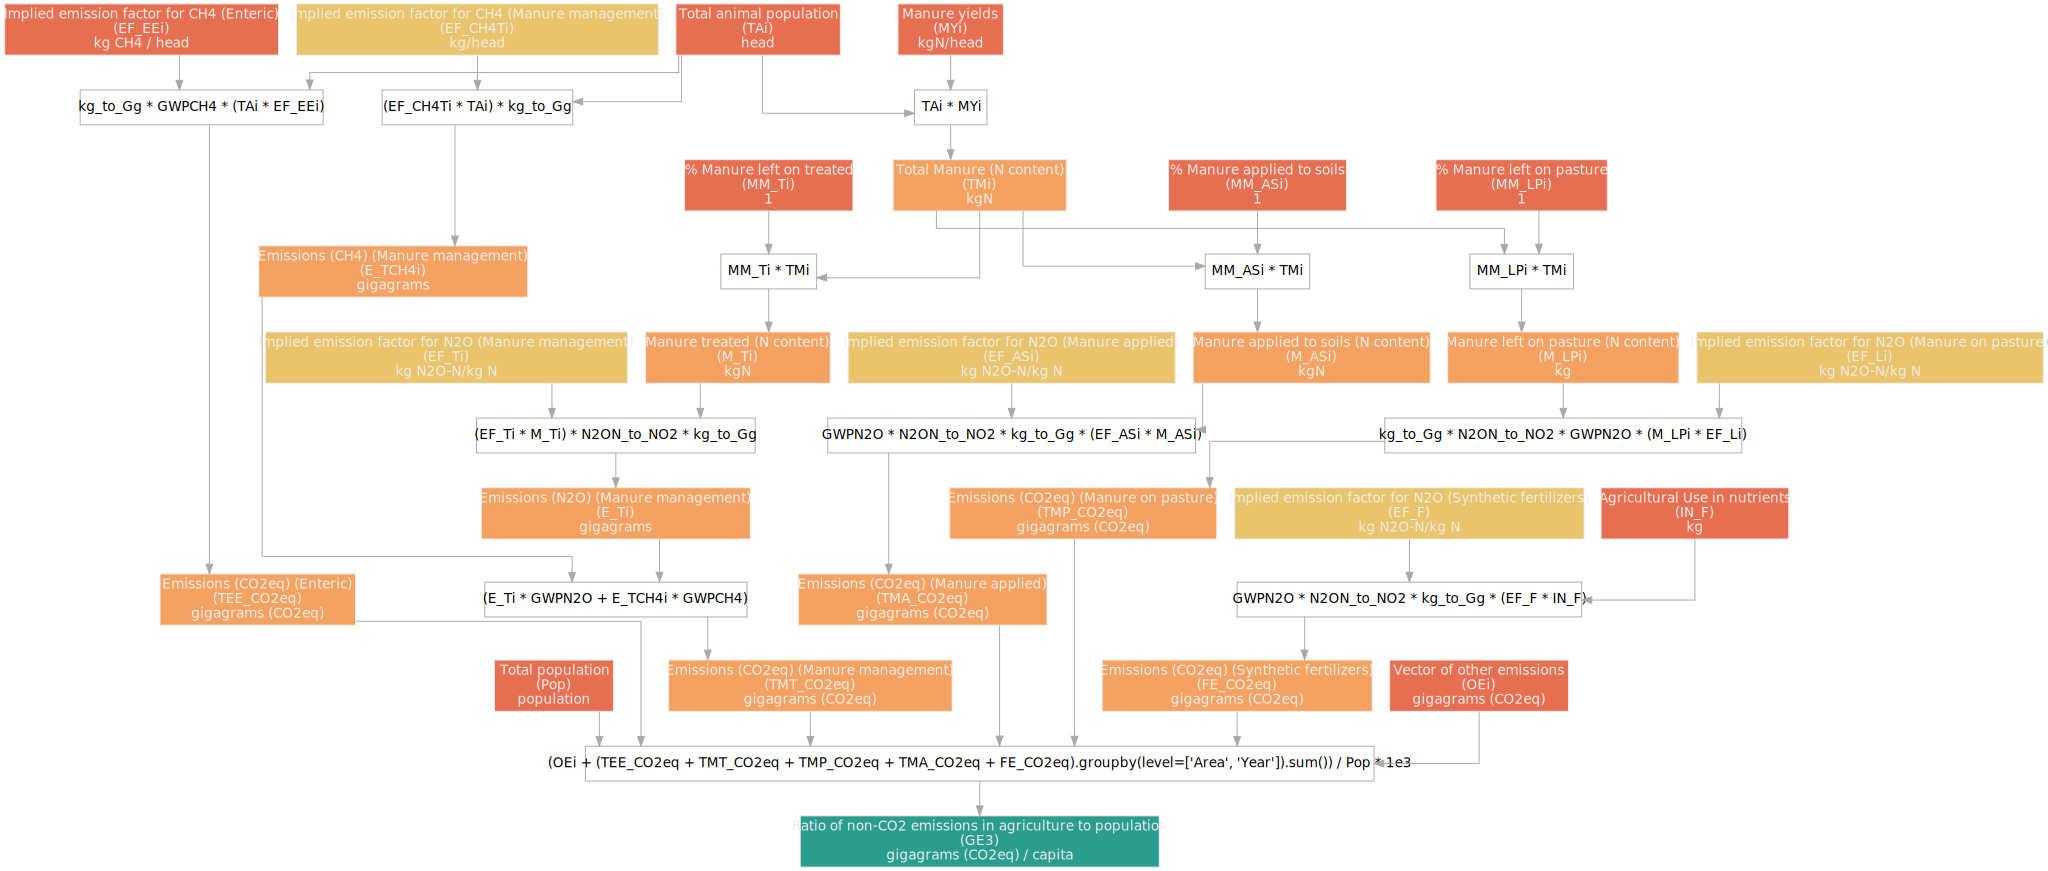

In [12]:
model.draw()

# TOTAL GRAPH

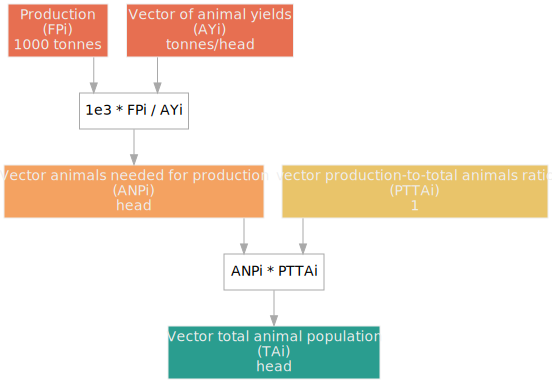

In [8]:

TAi_nodes = {'FPi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Production'},
             'AYi': {'type': 'input',
                     'unit': 'tonnes/head',
                     'name': 'Vector of animal yields'},
             'ANPi': {'type': 'variable',
                      'unit': 'head',
                      'name': 'Vector animals needed for production',
                      'computation': lambda FPi, AYi, **kwargs: 1e3 * FPi / AYi
                      },
             'PTTAi': {'type': 'parameter',
                       'unit': '1',
                       'name': 'vector production-to-total animals ratio',
                       },
             'TAi': {'type': 'output',
                      'unit': 'head',
                      'name': 'Vector total animal population',
                      'computation': lambda ANPi, PTTAi, **kwargs: ANPi * PTTAi
                      },
             }

TAi_model = GraphModel(TAi_nodes)

TAi_model.draw()